# Рекомендация тарифов

### Задача бизнеса

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят **построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».**

### Информация о данных

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

### Ход исследования

* 1) Открыть файл и изучить его
* 2) Разделить исходные данные на обучающую, валидационную и тестовую выборки.
* 3) Исследовать качество разных моделий
* 4) Проверить качество на тестовой выборке
* 5) Проверить модели на вменяемость

## Откройте и изучите файл

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
sns.set(color_codes=True)

from sklearn.model_selection import train_test_split as t_t_s
from sklearn.linear_model import LogisticRegression as LRC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.dummy import DummyClassifier
from catboost import CatBoostClassifier as CBC, Pool, metrics, cv

from sklearn.metrics import accuracy_score as a_s
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

from tqdm import tqdm
from statistics import mean

import warnings
warnings.filterwarnings("ignore")

s = 100500

In [2]:
try:
    df = pd.read_csv('/datasets/users_behavior.csv')
except:
    df = pd.read_csv('users_behavior.csv')
    
df.sample(5)

,calls,minutes,messages,mb_used,is_ultra
180,99.0,634.32,43.0,16436.32,0
3064,78.0,553.56,0.0,14544.55,0
2111,75.0,550.72,55.0,11258.72,0
2493,67.0,492.40,16.0,22783.19,0
493,31.0,210.44,19.0,27437.43,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


В таблице пропусков не обнаружено, посмотрим на дубликаты.

In [4]:
df.duplicated().sum()

0

Тоже в порядке. Посмотрим на распределение значений.

In [5]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


Распределения нормальные, медиана близка к среднему, что говорит о том что в таблице нет большого количества выбросов и данные  адекватны.

In [6]:
# Проверяю есть-ли клиенты у которых всё по нулям.
df.query('calls==0 and minutes==0 and messages==0 and mb_used==0')

,calls,minutes,messages,mb_used,is_ultra


Клиентов с нулевыми показателями так же не обнаружелось, это проверку делаю для того, чтобы убедиться, что в данных не было тех кто сразу же ушёл. Ведь если такие строки будут в данных, то для определения тарифа и обучения модели они будут бесполезны их скорее всего пришлось бы исключить.

### Вывод

С данными всё впорядке.
   * Если в describe посомтреть на целевой признак (тариф, которым пользуеться пользователь), то можно увидеть, что присутствует несбалансированность классов:
      * Пользователи тарифа Smart занимают примерно 70% данных, а Ultra - 30 % , а это вероятно скажется на проверку accuracy.

## Разбейте данные на выборки

Разделим данные на целевой признак и остальные.

In [7]:
#features
f =  df.drop(['is_ultra'],axis=1)
#target
t = df.is_ultra

Так как у нас нет тестовой выборки, то я разделю базовый набор по принципу 60-20-20: 60% - обущающая выборка, 20% - валидационная(проверочная), 20% - тестовая.

In [8]:
#делю выборку на 60-40
f_train, f_test, t_train,  t_test = t_t_s(f,
                                          t,
                                          test_size = 0.4,
                                          random_state = s,
                                          stratify = t)
#разбиваю 40 на 20-20
f_valid, f_test, t_valid,  t_test = t_t_s(f_test,
                                          t_test,
                                          test_size = 0.5,
                                          random_state = s,
                                          stratify = t_test)

In [9]:
#проверяю размер выборок
print(f_train.shape)
print(f_valid.shape)
print(f_test.shape)

(1928, 4)
(643, 4)
(643, 4)


In [10]:
#проверяю баланс таргетов
print(t_train.mean())
print(t_valid.mean())
print(t_test.mean())

0.3065352697095436
0.30637636080870917
0.30637636080870917


Всё в порядке, можно проводить исследование.

## Исследуйте модели

### Decision Tree

100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 97.36it/s]


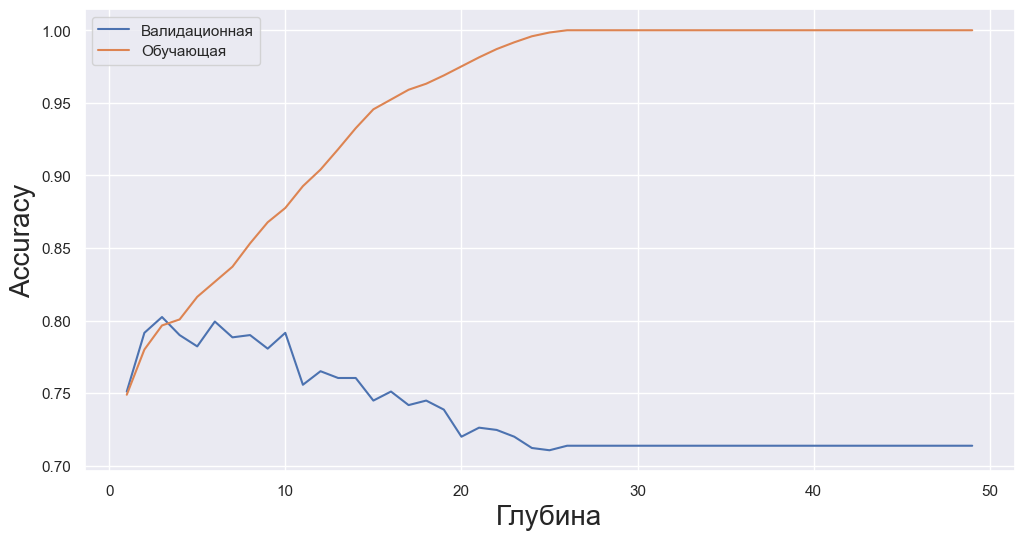

Максимальная глубина наилучшей модели Decision Tree на валидационной выборке: 3
Точность: 0.80248833592535
Wall time: 733 ms


In [11]:
%%time

best_DT = None
best_accuracy_DT = 0
best_depth_DT = 0

x=[]
y1=[]
y2=[]
for depth in tqdm(range(1,50)):
    DT = DTC(random_state = s, max_depth = depth)
    DT.fit(f_train,t_train)
    pred_v_DT = DT.predict(f_valid)
    pred_t_DT = DT.predict(f_train)
    accuracy_DT_v = a_s(pred_v_DT, t_valid)
    accuracy_DT_t = a_s(pred_t_DT, t_train)
    x.append(depth)
    y1.append(accuracy_DT_v)
    y2.append(accuracy_DT_t)
    if best_accuracy_DT < accuracy_DT_v:
        best_DT = DT 
        best_accuracy_DT = accuracy_DT_v
        best_depth_DT = depth
        
plt.figure(figsize=(12, 6))        
plt.plot(x, y1)
plt.plot(x, y2)
plt.legend(['Валидационная','Обучающая'])
plt.ylabel('Accuracy',size=20)
plt.xlabel('Глубина',size=20)
plt.show()
        
print('Максимальная глубина наилучшей модели Decision Tree на валидационной выборке:', best_depth_DT)
print('Точность:',best_accuracy_DT)


### Random Forest

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:24<00:00,  1.01s/it]


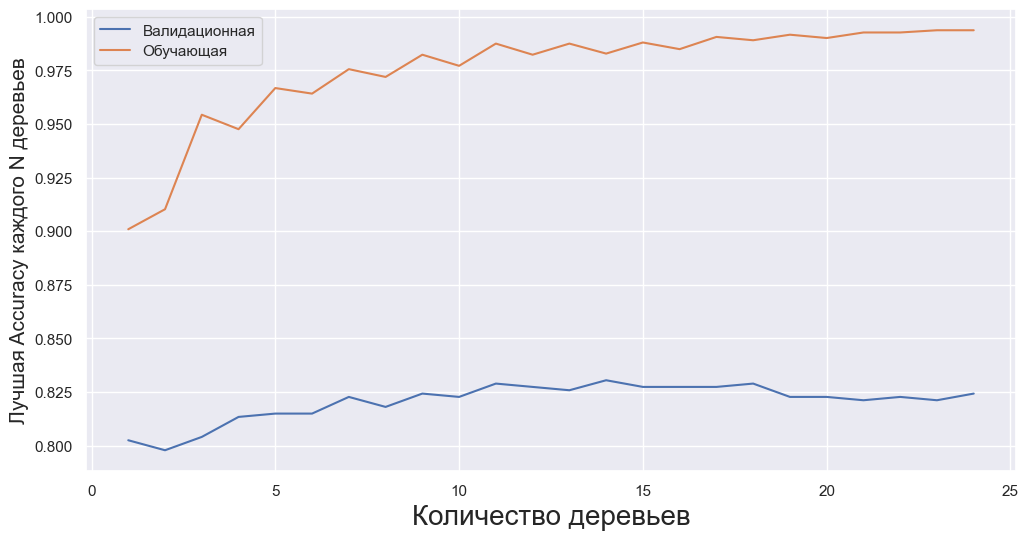

Максимальная глубина наилучшей модели Random Forest на валидационной выборке: 8
Количество деревьев наилучшей модели Random Forest на валидационной выборке: 14
Точность: 0.8304821150855366
Wall time: 24.4 s


In [12]:
%%time

best_RF = None
best_est_RF = 0
best_accuracy_RF = 0
best_depth_RF = 0

x=[]
y1=[]
y2=[]
for est in tqdm(range(1,25)):
    y_v=[]
    y_t=[]
    for depth in range(1,25):
        RF = RFC(random_state = s, max_depth = depth, n_estimators = est)
        RF.fit(f_train,t_train)
        pred_v_RF = RF.predict(f_valid)
        pred_t_RF = RF.predict(f_train)
        accuracy_RF_v = a_s(pred_v_RF, t_valid)
        accuracy_RF_t = a_s(pred_t_RF, t_train)
        y_v.append(accuracy_RF_v)
        y_t.append(accuracy_RF_t)
        if best_accuracy_RF < accuracy_RF_v:
            best_RF = RF 
            best_est_RF = est
            best_accuracy_RF = accuracy_RF_v
            best_depth_RF = depth
    x.append(est)
    y1.append(max(y_v))
    y2.append(max(y_t))
    
plt.figure(figsize=(12, 6)) 
plt.plot(x, y1)
plt.plot(x, y2)
plt.legend(['Валидационная','Обучающая'])
plt.ylabel('Лучшая Accuracy каждого N деревьев',size = 15)
plt.xlabel('Количество деревьев',size = 20)
plt.show()

print('Максимальная глубина наилучшей модели Random Forest на валидационной выборке:', best_depth_RF)
print('Количество деревьев наилучшей модели Random Forest на валидационной выборке:', best_est_RF)
print('Точность:',best_accuracy_RF)

### Logistic Regression

In [13]:
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

In [14]:
best_LR = None
best_solver_LR = None
best_accuracy_LR = 0


for sol in solvers:
    LR = LRC(solver=sol, max_iter=4000, random_state=s)
    LR.fit(f_train, t_train)
    pred_v_LR = LR.predict(f_valid)
    accuracy_LR = a_s(pred_v_LR, t_valid)
    print((f"{sol}: {accuracy_LR}"))
    if best_accuracy_LR < accuracy_LR:
            best_LR = LR 
            best_solver_LR = sol
            best_accuracy_LR = accuracy_LR
print("______________________")
print('Лучший параметр solver:',best_solver_LR)
print('Точность лучшей модели Logistic Regression на валидационной выборке:',best_accuracy_LR)

newton-cg: 0.76049766718507
lbfgs: 0.6998444790046656
liblinear: 0.6998444790046656
sag: 0.6982892690513219
saga: 0.6967340590979783
______________________
Лучший параметр solver: newton-cg
Точность лучшей модели Logistic Regression на валидационной выборке: 0.76049766718507


### CatBoost

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:59<00:00,  9.97s/it]


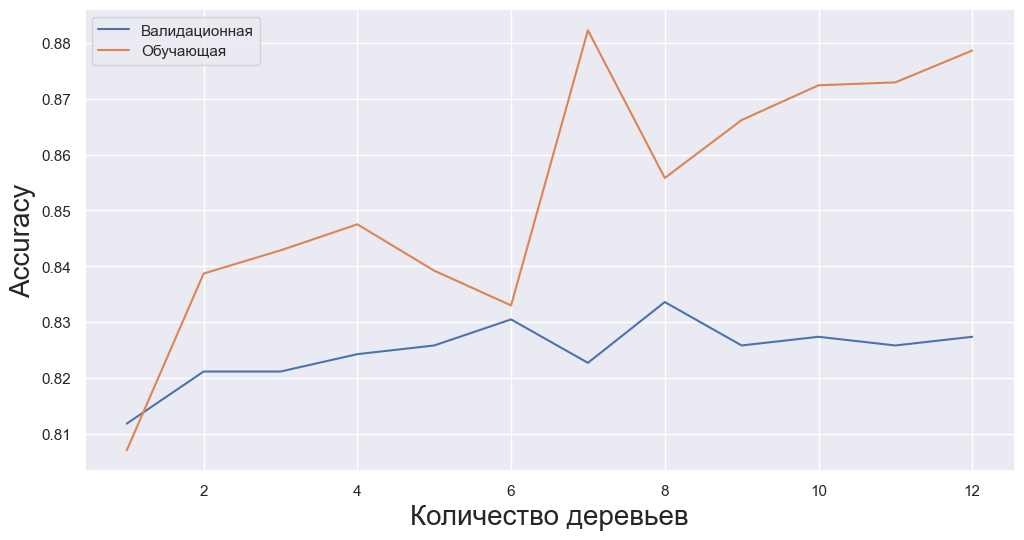

Максимальная глубина наилучшей модели CatBoost на валидационной выборке: 8
Точность: 0.833592534992224
Wall time: 1min 59s


In [15]:
%%time
best_CB = None
best_accuracy_CB = 0
best_depth_CB = 0
x = []
y1 = []
y2 = []


for depth in tqdm(range(1,13)):
    CB = CBC(iterations=1000,
             custom_loss=[metrics.Accuracy()],
             random_seed=s,
             logging_level='Silent', 
             depth = depth
             )
    CB.fit(
           f_train, t_train,
           cat_features=np.where(f.dtypes != float)[0],
           eval_set=(f_valid, t_valid)
           )
    pred_v_CB = CB.predict(f_valid)
    pred_t_CB = CB.predict(f_train)
    accuracy_CB_v = a_s(pred_v_CB, t_valid)
    accuracy_CB_t = a_s(pred_t_CB, t_train)
    x.append(depth)
    y1.append(accuracy_CB_v)
    y2.append(accuracy_CB_t)
    if best_accuracy_CB < accuracy_CB_v:
        best_CB = CB 
        best_accuracy_CB = accuracy_CB_v
        best_depth_CB = depth
        
plt.figure(figsize=(12, 6)) 
plt.plot(x, y1)
plt.plot(x, y2)
plt.legend(['Валидационная','Обучающая'])
plt.ylabel('Accuracy',size = 20)
plt.xlabel('Количество деревьев',size = 20)
plt.show()

print('Максимальная глубина наилучшей модели CatBoost на валидационной выборке:', best_depth_CB)
print('Точность:',best_accuracy_CB)

### Вывод

In [16]:
print(f"Decision Tree: {best_accuracy_DT}")
print(f"Random Forest: {best_accuracy_RF}")
print(f"Logistic Regression: {best_accuracy_LR}")
print(f"CatBoost: {best_accuracy_CB}")

Decision Tree: 0.80248833592535
Random Forest: 0.8304821150855366
Logistic Regression: 0.76049766718507
CatBoost: 0.833592534992224


Самыми лучшими по точности вышли CatBoost(83.35) и Random Forest (83.04), на втором месте Decision Tree (80.24), самая неточная модель получилась Logistic Regression с результатом (76.05).

## Проверьте модель на тестовой выборке

In [17]:
# соединяю train и valid выборки и переобучаю модель на полном наборе данных.
t_train2 = pd.concat([t_train,t_valid],sort=False,axis=0)
f_train2 = pd.concat([f_train,f_valid],sort=False,axis=0)

best_CB.fit(f_train, t_train,
            cat_features=np.where(f.dtypes != float)[0],
            )

In [18]:
#prediction_test
pred_t_CB = best_CB.predict(f_test)

#accuracy_test
ac_t_CB = a_s(pred_t_CB, t_test)

print("Точность модели")
print(f"CatBoost: {round(ac_t_CB,4)*100}%")

Точность модели
CatBoost: 81.03%


### Вывод

Самой эффективной по точности и скорости моделью является CatBoost, практически такие же результаты показывает Random Forest. На следующем месте Decision Tree. Самой неэффективной моделью стала Logistic Regression.

По поводу применения в бизнесе. Данная модель позволит работать как со старыми так и сновыми клиентами.
* Установлено, что есть старые клиенты, которые пользуються устаревшими тарифами, эта модель поможет каждому педложить наиболее актуальный тариф.
* Так же с новыми клиентами, клиент, можно быстро рассчитывать подходящий человеку тариф.

## (бонус) Проверьте модели на адекватность

Для того чтобы оценить модель на её адекватность (sanity check - "проверить на вменяемость") сравню её работу с случаными предсказаниями.

In [19]:
#random_answers
r_a = np.random.randint(0, 2, size=643)

#accuracy_random_test
a_r_t = round(a_s(t_test, r_a), 4)
a_r_t

0.5288

Все модели показали результат лучше, чем случайный массив предсказаний. Проверим на фиктивном модели-класификаторе, которая всегда предсказывает наиболее частую метку класса в обучающих данных.

In [20]:
dummy = DummyClassifier(strategy="most_frequent")

In [21]:
dummy.fit(f_train, t_train)
d_p = dummy.predict(f_test)
ac_t_dummy = a_s(d_p, t_test)
print("Точность фиктивной модели")
print(f"Dummy: {round(ac_t_dummy,4)*100}%")

Точность фиктивной модели
Dummy: 69.36%


### Вывод

Итоги проверки на адекватность - выбранная модель CatBoost предсказывает результат лучше чем фиктивная модель и случайный массив данных, а значит работает адекватно.